In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load dataset
df = pd.read_csv("/kaggle/input/water-quality/water_quality.csv")

df.head()

,Well_ID,State,District,Block,Village,Latitude,Longitude,Year,pH,EC,...,NO3,TH,Ca,Mg,Na,K,F,TDS,WQI,Water Quality Classification
0,W232200071580001,Gujarat,Ahmedabad,Mandal,Dalod,NaN,NaN,2020,8.20,16640.0,...,26.00,1451.0,152.0,260.0,3535.0,45.0,1.00,11149,4361.44080,Unsuitable for Drinking
1,W254029084355301,Himachal Pradesh,Solan,Nallagarh,JAGATPUR,31.1594,76.678500,2019,8.44,299.0,...,2.70,84.0,17.0,10.0,39.0,2.4,0.20,262,85.80466,Good
2,W193530074180001,Maharashtra,Ahmednagar,SANGAMNER,Kokangaon,74.3000,19.591667,2022,7.90,1315.0,...,18.20,465.0,80.2,64.4,88.3,1.6,0.53,372,280.04130,Very Poor yet Drinkable
3,W231620072033001,Gujarat,Ahmedabad,Viramgam,Endla,NaN,NaN,2020,7.40,715.0,...,0.23,280.0,56.0,34.0,47.0,11.0,0.46,479,195.11649,Poor
4,W251908084361501,Himachal Pradesh,Solan,Nallagarh,BARUNA,31.1540,76.638400,2019,8.40,270.0,...,10.00,116.0,10.0,18.0,23.0,1.0,0.12,262,81.77860,Good


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl                            19029 non-null  float64
 13  S

In [23]:
df["Water Quality Classification"].value_counts()

Water Quality Classification
Unsuitable for Drinking    6078
Poor                       5088
Very Poor yet Drinkable    4516
Good                       1467
Excellent                   678
Name: count, dtype: int64

In [5]:
df.isna().sum()

Well_ID                         3785
State                              0
District                           0
Block                           1119
Village                            1
Latitude                         389
Longitude                        390
Year                               0
pH                                 0
EC                                 0
CO3                                0
HCO3                               0
Cl                                 0
SO4                                0
NO3                                0
TH                                 0
Ca                                 0
Mg                                 0
Na                                 0
K                                  0
F                                  0
TDS                                0
WQI                                0
Water Quality Classification       0
dtype: int64

In [6]:
# Impute missing values in 'Village' using the most frequent village within the same (State, District, Block)

# Define a function to get the most frequent village in each group
def impute_village(group):
    most_frequent_village = group['Village'].mode()
    if not most_frequent_village.empty:
        group['Village'].fillna(most_frequent_village.iloc[0], inplace=True)
    return group

# Apply imputation by grouping on State, District, and Block
df = df.groupby(['State', 'District', 'Block'], group_keys=False).apply(impute_village)

# Check if any missing values remain in the Village column
df['Village'].isnull().sum()

0

In [7]:
# Function to impute missing 'Block' values using the most frequent Block within the same State & District
def impute_block(group):
    most_frequent_block = group['Block'].mode()
    if not most_frequent_block.empty:
        group['Block'].fillna(most_frequent_block.iloc[0], inplace=True)
    return group

# Apply imputation by grouping on State & District
df = df.groupby(['State', 'District'], group_keys=False).apply(impute_block)

# Check if any missing values remain in the Block column
df['Block'].isnull().sum()

0

In [8]:
# Function to impute missing Latitude & Longitude using mean values within the same State & District
def impute_lat_lon(group):
    group['Latitude'].fillna(group['Latitude'].mean(), inplace=True)
    group['Longitude'].fillna(group['Longitude'].mean(), inplace=True)
    return group

# Apply imputation by grouping on State & District
df = df.groupby(['State', 'District'], group_keys=False).apply(impute_lat_lon)

# Check if any missing values remain in the Latitude & Longitude column
df[['Latitude', 'Longitude']].isnull().sum()

Latitude     78
Longitude    78
dtype: int64

In [9]:
# Drop rows where Latitude or Longitude is still missing
df = df.dropna(subset=['Latitude', 'Longitude'])

# Confirm that no missing values remain in these columns
df[['Latitude', 'Longitude']].isnull().sum()


Latitude     0
Longitude    0
dtype: int64

In [10]:
df.drop(columns=['Well_ID'], inplace=True)

In [11]:
df.duplicated().sum()

5

In [12]:
# Drop duplicate rows from the dataset
df = df.drop_duplicates()

# Verify that all duplicates are removed
df.duplicated().sum()


0

In [13]:
# Encode categorical variables
categorical_cols = ['State', 'District', 'Block', 'Village']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [14]:
# Separate features and targets
X = df.drop(columns=['WQI', 'Water Quality Classification'])
y_reg = df['WQI'].values  # Regression target
y_class = df['Water Quality Classification'].astype('category').cat.codes.values  # Classification target

In [15]:
# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Train-test split
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X_scaled, y_reg, y_class, test_size=0.15, random_state=42)

X_train, X_val, y_reg_train, y_reg_val, y_class_train, y_class_val = train_test_split(
    X_train, y_reg_train, y_class_train, test_size=0.1, random_state=42
)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 13636
Validation set size: 1516
Test set size: 2675


In [17]:
# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_reg_train_tensor = torch.tensor(y_reg_train, dtype=torch.float32).to(device)
y_reg_test_tensor = torch.tensor(y_reg_test, dtype=torch.float32).to(device)
y_reg_val_tensor = torch.tensor(y_reg_val, dtype=torch.float32).to(device)
y_class_train_tensor = torch.tensor(y_class_train, dtype=torch.long).to(device)
y_class_test_tensor = torch.tensor(y_class_test, dtype=torch.long).to(device)
y_class_val_tensor = torch.tensor(y_class_val, dtype=torch.long).to(device)

In [20]:
# Custom Dataset class
class WaterQualityDataset(Dataset):
    def __init__(self, X, y_reg, y_class):
        self.X = X
        self.y_reg = y_reg
        self.y_class = y_class

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_reg[idx], self.y_class[idx]

# Create DataLoader
batch_size = 32
train_dataset = WaterQualityDataset(X_train_tensor, y_reg_train_tensor, y_class_train_tensor)
test_dataset = WaterQualityDataset(X_test_tensor, y_reg_test_tensor, y_class_test_tensor)
val_dataset = WaterQualityDataset(X_val_tensor, y_reg_val_tensor, y_class_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the Multi-Task Learning Model
class MultiTaskNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiTaskNN, self).__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Regression Head
        self.regression_head = nn.Linear(64, 1)

        # Classification Head
        self.classification_head = nn.Linear(64, num_classes)

    def forward(self, x):
        shared_out = self.shared_layers(x)
        reg_out = self.regression_head(shared_out)  # WQI prediction
        class_out = self.classification_head(shared_out)  # Classification
        return reg_out, class_out

# Initialize model
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_class))
model = MultiTaskNN(input_dim, num_classes).to(device)

# Define loss functions and optimizer
criterion_reg = nn.MSELoss()
criterion_class = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Training loop

epochs = 50
best_val_loss = float('inf')
best_val_accuracy = 0
best_val_f1 = 0
best_val_r2 = float('-inf')

val_accuracies = []
val_f1_scores = []
val_r2_scores = []

for epoch in range(epochs):
    model.train()
    total_loss, total_reg_loss, total_class_loss = 0, 0, 0

    for X_batch, y_reg_batch, y_class_batch in train_loader:
        optimizer.zero_grad()

        reg_pred, class_pred = model(X_batch)

        loss_reg = criterion_reg(reg_pred.squeeze(), y_reg_batch)
        loss_class = criterion_class(class_pred, y_class_batch)
        loss = loss_reg + loss_class  # Combined loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_reg_loss += loss_reg.item()
        total_class_loss += loss_class.item()

    # Compute average training loss
    avg_train_loss = total_loss / len(train_loader)
    avg_reg_loss = total_reg_loss / len(train_loader)
    avg_class_loss = total_class_loss / len(train_loader)

    # Validation Phase
    model.eval()
    val_loss, val_reg_loss, val_class_loss = 0, 0, 0
    y_reg_preds, y_class_preds = [], []
    y_reg_true, y_class_true = [], []

    with torch.no_grad():
        for X_batch, y_reg_batch, y_class_batch in val_loader:
            reg_pred, class_pred = model(X_batch)

            loss_reg = criterion_reg(reg_pred.squeeze(), y_reg_batch)
            loss_class = criterion_class(class_pred, y_class_batch)
            loss = loss_reg + loss_class  # Combined loss

            val_loss += loss.item()
            val_reg_loss += loss_reg.item()
            val_class_loss += loss_class.item()

            y_reg_preds.extend(reg_pred.cpu().numpy())
            y_class_preds.extend(torch.argmax(class_pred, dim=1).cpu().numpy())
            y_reg_true.extend(y_reg_batch.cpu().numpy())
            y_class_true.extend(y_class_batch.cpu().numpy())

    # Compute average validation loss
    avg_val_loss = val_loss / len(val_loader)
    avg_val_reg_loss = val_reg_loss / len(val_loader)
    avg_val_class_loss = val_class_loss / len(val_loader)

    # Compute validation metrics
    y_reg_preds = np.array(y_reg_preds).flatten()
    y_class_preds = np.array(y_class_preds)
    val_r2 = r2_score(y_reg_true, y_reg_preds)
    val_accuracy = accuracy_score(y_class_true, y_class_preds)
    val_f1 = f1_score(y_class_true, y_class_preds, average='weighted')

    # Store validation accuracy and F1 score for final print
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_r2_scores.append(val_r2)

    # Save best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_val_r2 = val_r2
        best_val_accuracy = val_accuracy
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} (Reg: {avg_reg_loss:.4f}, Class: {avg_class_loss:.4f}) | "
          f"Val Loss: {avg_val_loss:.4f} (Reg: {avg_val_reg_loss:.4f}, Class: {avg_val_class_loss:.4f})")

print("\n-----------------------------------------------------\n")

# Print final r2, validation accuracy and F1 score
print("\nFinal Validation Results:")
print(f"Best Validation R² Score: {best_val_r2:.4f}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Best Validation F1 Score: {best_val_f1:.4f}")

# Load best model for final test evaluation
model.load_state_dict(torch.load("best_model.pth"))


Epoch [1/50] - Train Loss: 76795.4505 (Reg: 76794.2765, Class: 1.1745) | Val Loss: 5150.2386 (Reg: 5149.3799, Class: 0.8586)
Epoch [2/50] - Train Loss: 5738.5802 (Reg: 5737.7707, Class: 0.8095) | Val Loss: 1935.2676 (Reg: 1934.4738, Class: 0.7938)
Epoch [3/50] - Train Loss: 2585.2578 (Reg: 2584.5317, Class: 0.7261) | Val Loss: 794.7574 (Reg: 794.1164, Class: 0.6410)
Epoch [4/50] - Train Loss: 1270.8162 (Reg: 1270.1996, Class: 0.6166) | Val Loss: 462.3819 (Reg: 461.8054, Class: 0.5765)
Epoch [5/50] - Train Loss: 602.8144 (Reg: 602.2536, Class: 0.5608) | Val Loss: 263.1779 (Reg: 262.6190, Class: 0.5588)
Epoch [6/50] - Train Loss: 275.9567 (Reg: 275.3734, Class: 0.5833) | Val Loss: 163.5990 (Reg: 163.0826, Class: 0.5164)
Epoch [7/50] - Train Loss: 156.0939 (Reg: 155.5371, Class: 0.5568) | Val Loss: 103.3373 (Reg: 102.7999, Class: 0.5374)
Epoch [8/50] - Train Loss: 99.1106 (Reg: 98.5598, Class: 0.5508) | Val Loss: 73.5378 (Reg: 73.0428, Class: 0.4949)
Epoch [9/50] - Train Loss: 62.9108 (Re

<All keys matched successfully>

In [22]:
# Final Test Evaluation
model.eval()
y_reg_preds, y_class_preds = [], []
y_reg_true, y_class_true = [], []

with torch.no_grad():
    for X_batch, y_reg_batch, y_class_batch in test_loader:
        reg_pred, class_pred = model(X_batch)

        y_reg_preds.extend(reg_pred.cpu().numpy())
        y_class_preds.extend(torch.argmax(class_pred, dim=1).cpu().numpy())
        y_reg_true.extend(y_reg_batch.cpu().numpy())
        y_class_true.extend(y_class_batch.cpu().numpy())

# Convert predictions to numpy arrays
y_reg_preds = np.array(y_reg_preds).flatten()
y_class_preds = np.array(y_class_preds)

# Compute test metrics
test_r2 = r2_score(y_reg_true, y_reg_preds)
test_accuracy = accuracy_score(y_class_true, y_class_preds)
test_f1 = f1_score(y_class_true, y_class_preds, average='weighted')

print(f"Final Test Results:\n"
      f"Regression R² Score: {test_r2:.4f}\n"
      f"Classification Accuracy: {test_accuracy:.4f}\n"
      f"Classification F1 Score: {test_f1:.4f}")

Final Test Results:
Regression R² Score: 1.0000
Classification Accuracy: 0.9163
Classification F1 Score: 0.9163


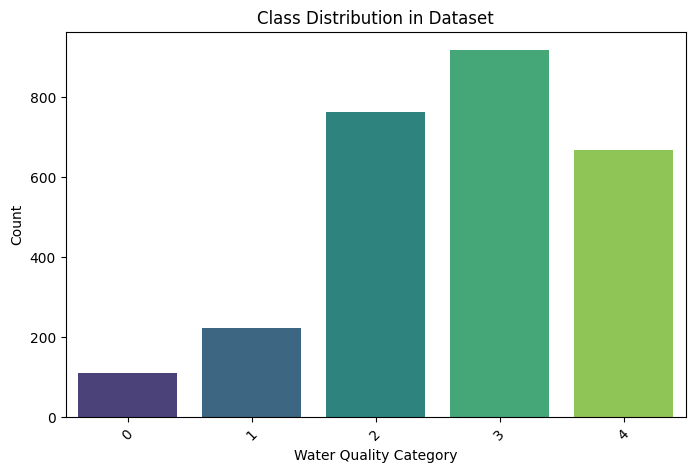

In [ ]:
# Class Distribution Bar Chart
plt.figure(figsize=(8, 5))
unique_classes, class_counts = np.unique(y_class_true, return_counts=True)
sns.barplot(x=unique_classes, y=class_counts, palette='viridis')
plt.xlabel("Water Quality Category")
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)
plt.show()

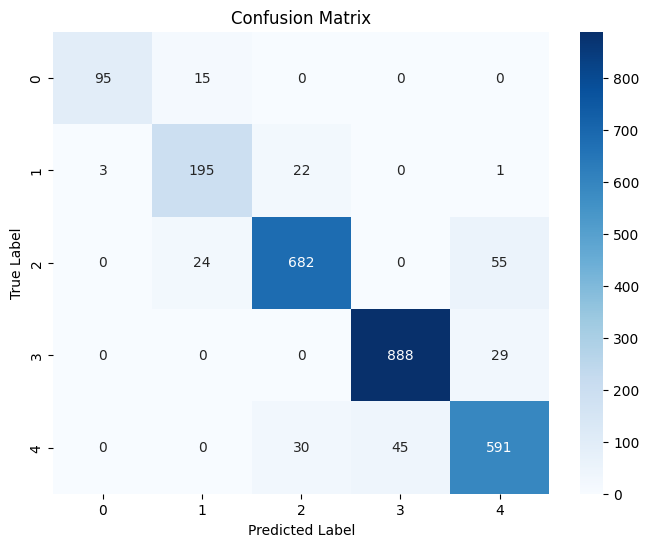

In [26]:
conf_matrix = confusion_matrix(y_class_true, y_class_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

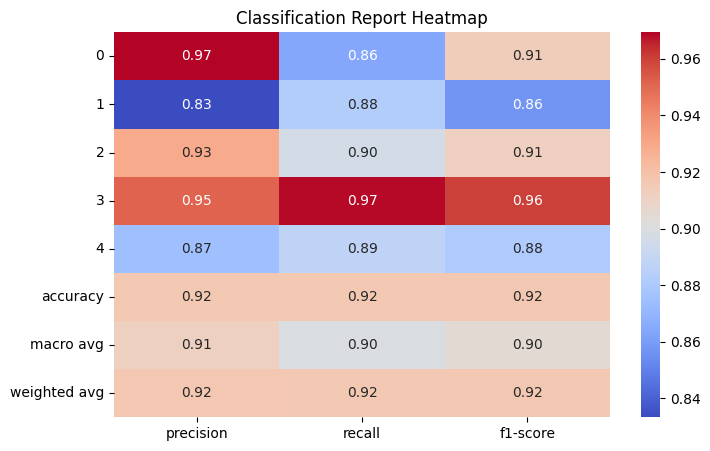

In [27]:
# Classification Report Heatmap
class_report = classification_report(y_class_true, y_class_preds, output_dict=True)
report_df = pd.DataFrame(class_report).iloc[:-1, :].T
plt.figure(figsize=(8, 5))
sns.heatmap(report_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Classification Report Heatmap")
plt.show()

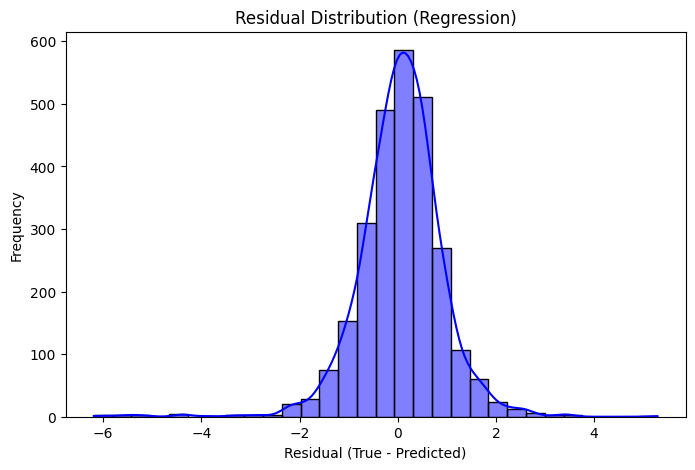

In [28]:
# Regression Residual Analysis
residuals = np.array(y_reg_true) - np.array(y_reg_preds)

# Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Regression)")
plt.show()

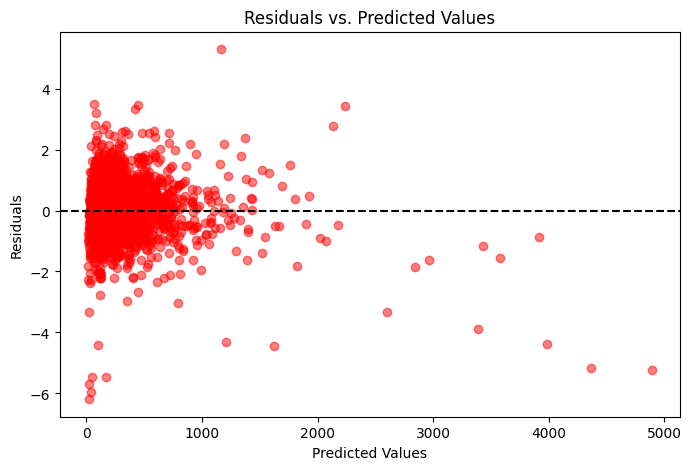

In [29]:
# Scatter Plot of Residuals
plt.figure(figsize=(8, 5))
plt.scatter(y_reg_preds, residuals, alpha=0.5, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()